<a href="https://colab.research.google.com/github/ttourneux/Final-Project/blob/main/Assignment_3A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## questions 
1. should we call transform on our data or only in get_item? 
  - we should transform our whole dataset which will be (nsamples, 28,28)


3. for data aumentation for part 3, how much do we need for full credit

4. should I make a new training loop for the transfer learning? 

5. should I have made the loss function a paramter of the model? 

## still to do :     
### Part 1: 
1. everything looks good 
### part2: 
4. return the best model in the training loop. 
  - use 
  - model_clone = model_cls(**kwargs)
  - model_clone.load_state_dict(copy.deepcopy(original_model.state_dict()))


### part 3
1. add extra data augementations

3. use test data ie compare test performance of Linear Classifers and CNN.- I think this is where we use the test data.

### Author Information
Name: Theodore Tourneux

B-Number: NA

Email: ttourne1@binghamton.edu

## General Instructions 
### Due November 11th, 11:59 PM.

In the following assignment, you will be using the deep learning framework, PyTorch, to perform computer vision tasks such as image classification and object detection. This will be a report-style assignment, where you will try multiple different models, optimization algorithms, and hyperparameters, and present your findings in a short report with visualizations inside the notebook.  


Functions and cells that need to be implemented are marked with a bold **implement** keyword or clearly marked in the experiments section. 

The experiments section for each classifier also need to be implemented. You should follow the instructions above the cell. You may also add additional cells. 

Cells marked **run** need to be run to set up the appropriate infrastructure, but do not need to be modified. Make sure you have run the previous cells before running the current cell, or you may get an error.

It is standard practice in ML to share notebooks to discuss the workflow and results in a professional setting. So, the code quality also matters. You should make sure your code is readable and conforms to standard practices. Your figures should be intelligable and include proper axis labels, titles, and legends. Unreadable and poorly written code may result in a points deduction.  

Submission will be via GitHub Classroom. **You are required to have at least 10 commits for this assignment.**

## Uploading and Downloading Data from Colab

Unlike the previous assignments, you will downloading and uploading additional data from and into the Colab environment. 

You can mount directories from your Google Drive and use the session storage for your work. 

[Take a look here for an example notebook on handling data download and upload on Colab. ](https://colab.research.google.com/notebooks/io.ipynb#scrollTo=hauvGV4hV-Mh)

## Import statements

**Run** the cell to import the packages needed for the code below. You may other packages but ask first. 

In [4]:
import torch
import csv
import matplotlib.pyplot as plt
import cv2 as cv
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils



from tqdm import tqdm
import pandas as pd 
import seaborn as sns
from PIL import Image
import copy

from sklearn.metrics import plot_confusion_matrix
#from torchmetrics import ConfusionMatrix

ModuleNotFoundError: ignored

In [ ]:
torch.manual_seed(42)  # Set the seed for the random number generator 

## CUDA Runtime

You will want to make use of the GPU runtimes on Colab to speed up your training. You can change your runtime by going to:

`Runtime > Change runtime type` and selecting GPU. 

You will have to explicitly use the send Torch tensors to GPUs, by calling `.cuda()`  on the tensors and modules to utilize them on the GPU.

[Take a look at the quickstart for PyTorch](https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html)

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


## Part 1: Data Handling in PyTorch (20 pts)

### Dataset class

A large part of any machine learning workflow is the proper and efficient handling of data. Datasets are often large, scattered across filesystems, and require transformations and augmentation. Deep learning libraries such as `PyTorch` provide utilities to help in this process. In the next section, you will write a custom MNIST dataset and add data augmentation to your data pipeline for your traininig. 

**Run** the following cell to define some helper functions to load the MNIST data.

In [6]:
def _data_parser_helper(csv_file_name):
  '''
  Reads CSV file and converts it into numpy arrays.

  Args:
    csv_file_name (string): String of the path of csv file. 

  Returns:
    (np.array(float), np.array(int)): Returns a tuple of numpy arrays. 
  '''
  X = []
  Y = []
  with open(csv_file_name,'r') as _file:
      csv_reader = csv.reader(_file, delimiter=",")
      for row in csv_reader:
          Y.append(int(row[0]))
          X.append([float(i)/255.0 for i in row[1:]])
  return (np.array(X), np.array(Y))

def get_mnist_train_data():
  X_train, Y_train = _data_parser_helper("sample_data/mnist_train_small.csv")
  return X_train, Y_train

def get_mnist_test_data():
  X_test, Y_test = _data_parser_helper("sample_data/mnist_test.csv")
  return X_test, Y_test

***Implement*** the `MNIST` class to serve as a container for our PyTorch MNIST data. [Take a look at this tutorial on PyTorch datasets, dataloading, and transforms.](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html#dataset-class)
[This second, more important tutorial specifically covers custom datasets and dataloaders.](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#creating-a-custom-dataset-for-your-files)

The MNIST data on Colab is pre-installed on all notebooks as a CSV.
Your class must read the data and store it as PyTorch float tensors. 
Use the helper functions above (already written) to read the data,
which will return the data as NumPy arrays.

You should implement:

- `__init__()` to read the appropriate CSV file, and store it in the class as a `torch.Tensor` with float dtype. 
- `__len__()` to return the number of samples in the dataset. 
- `__getitem__(i)` to return the i-th sample and label from the data you have stored. 

In [7]:
X_train, Y_train = get_mnist_train_data()

In [8]:
type(X_train)

numpy.ndarray

In [9]:
X_train.shape

(20000, 784)

In [10]:
class MNIST(Dataset):
  """MNIST custom dataset that reads the CSV file and transforms them into PyTorch Tensors"""


  def __init__(self, is_training=True, transform=None):

    """
    Args:
      is_training (bool): If true loads 
        the training dataset. If false, loads the test dataset. 
        Use the functions above.
      transform (callable): Transform to be applied on a sample.
        These will be used for data augmentations.
    """
    if(is_training):
      D = get_mnist_train_data() 
    else: 
      D = get_mnist_test_data()
    
    #self.data
    self.X,self.Y = torch.from_numpy(D[0]), torch.from_numpy(D[1])

    #trans_data = transform(self.data)
    self.transform = transform

    #self.XT,self.Y, = 

  def __len__(self):
    Y = self.Y## should be the y
    return(len(Y))
    
    """Returns the size (the number of samples) of the dataset.
    """

    

  def __getitem__(self, i):
    """Returns the i-th sample and label and applies any transforms defined.

      Args:
        i (int): The index of sample in the data array to retrieve. 
    """
    if self.transform == None:
      return self.X[i,:].reshape((28,28)) , self.Y[i] ## for X we want the specific row and all the columns. 
    else: 
      return self.transform(self.X[i,:].reshape((1,28,28))).reshape(28,28) , self.Y[i]
    

***Implement*** the following cell to visualize the data in the dataset. Use `Matplotlib` or your favorite visualization package to plot 5 images of each class in a single figure. 

You should initialize a MNIST dataset object for the training class. Visualize this dataset. This will not be used in the future.  



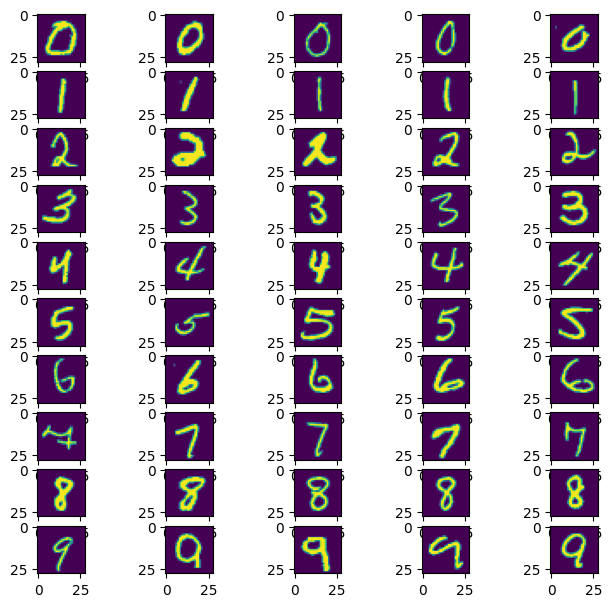

In [11]:
#redo

training_mnist = MNIST()

figure = plt.figure(figsize=(8, 8))
cols, rows = 5, 11



img_num = 0 
num = 0 
count =0 
for i in range(len(training_mnist)):
  x,y = training_mnist[i]
  if y == num: 
    
    figure.add_subplot(rows, cols, img_num+1)
    plt.imshow(x.reshape((28,28)))
    img_num +=1
    count+=1
    if count ==5: 
      num+=1
      count = 0
  if num >9:
    break

plt.show()

***Implement***
the following cell to create a PyTorch transform object and
assign it to a variable.
You may name the variable whatever you wish;
you will use the object to construct train and test MNIST datasets.

You will use the transformations defined in `torchvision`,
which can be found [here](https://pytorch.org/vision/stable/transforms.html#transforms-on-pil-image-and-torch-tensor).

Add the `RandomRotation` and `Normalize` transformations to the dataset. You will need to [compose the two transforms](https://pytorch.org/vision/0.9/transforms.html#torchvision.transforms.Compose). Restrict the rotations to +/- 15 degrees. 

The mean and standard deviation of the training set is 0.13 and 0.31 respectively.

At the end of the cell, construct a training and test dataset.
Name these carefully, these datasets will be used in the next sections.

In [12]:
trans = transforms.Compose([
     transforms.RandomRotation(degrees = 15),
     transforms.Normalize(.13, .31, inplace=False),
 ])

In [13]:
testing_mnist = MNIST(is_training = False, transform = trans)

***Implement*** the following cell to visualize the data in the dataset with the transformations similar to the previous visualization. 

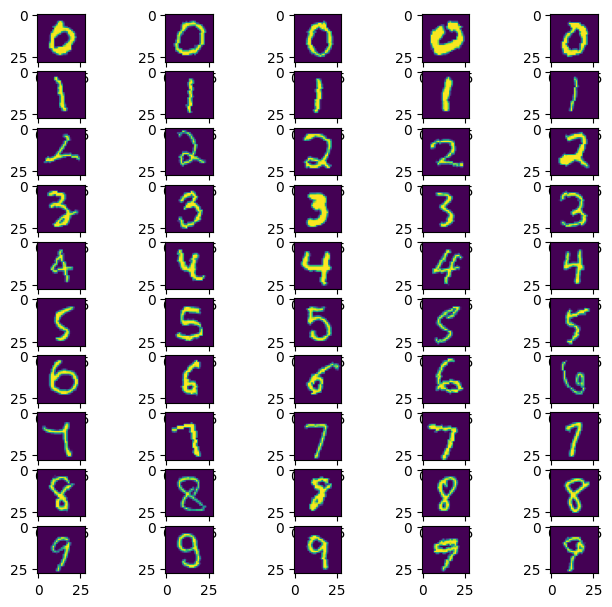

In [14]:
training_mnist = MNIST(is_training = False ,transform = trans)

figure = plt.figure(figsize=(8, 8))
cols, rows = 5, 11



img_num = 0 
num = 0 
count =0 
for i in range(len(training_mnist)):
  x,y = training_mnist[i]
  if y == num: 
    
    figure.add_subplot(rows, cols, img_num+1)
    plt.imshow(x.reshape((28,28)))
    img_num +=1
    count+=1
    if count ==5: 
      num+=1
      count = 0
  if num >9:
    break

plt.show()

***Implement*** the following cell to randomly split the training dataset previously defined, and make a training and validation set. Do an 80-20 split for the training and validation set. Name these sets carefully, they will be used in the next section to train your models. 

You can use the utilities in `torch.utils.data`.

In [15]:
mnist_train, mnist_val = torch.utils.data.random_split(training_mnist, lengths =[int(len(training_mnist)*.80),int(len(training_mnist)*.2)])

## Part 2: MNIST Classification (40 pts)

### Linear Classifiers

The linear classifiers you implemented in the last assignment will serve as our baseline for more powerful convolutional neural networks. You will ***implement*** the multi-class SVM and  Softmax classifiers in the following cells.  

**Implement** a LinearSVM classifier in the following cell. Your implementation should be a python class that inherits from `torch.nn.Module`. 

You should use classes and functions defined in `torch.nn` and `torch.nn.Functional`.   

In [16]:
BATCH_SIZE = 16 ## this is just a place holder 

class LinearSVM(nn.Module):
  ''' Implements the linear SVM using Torch.
  '''
  def __init__(self, num_classes, *args, **kwargs):
    '''
      num_classes (int): The number of output classes
    '''
    #super(LinearSVM, self).__init__()
    super().__init__()
    self.num_classes = num_classes

    self.layer1 = nn.Linear(28*28, num_classes)

    #self.layer1 = nn.Linear(28*28, 512)
    #self.layer2 = nn.Linear(512, 128)
    #self.layer3 = nn.Linear(128,64 )
    #self.layer_out = nn.functional.softmax(64,self.num_classes)
    #self.layer_out = nn.

  def forward(self, x, BATCH_SIZE = BATCH_SIZE):
    '''
      x (torch.Tensor): Input image as a torch tensor. 
    '''
    #x = x.reshape(28*28,10)
    x = self.layer1(x)


    return x 


***Implement*** using any PyTorch defined optimizer, code to train your LinearSVM classifier on the training dataset. You will want to try different optimizers, learning rates, and batch sizes. 

PyTorch provides implementations of various optimization algorithms in the `torch.optim` package. You can use any of the first order methods such as:

- SGD (with or without momentum)
- AdaDelta
- ADAM
- RProp
- RMSProp

***Note:*** You should keep track of the performance of the optimizers, batch sizes, and learning rates. You should justify the choice of your hyperparameters in the report at the end of this section. You will be asked to quantify and visualize the differences between these hyperparameters. 

You should use `Torch.utils.data.DataLoader` to do the data loading. Make sure to use the correct loss function. You may use the predefined loss functions available in `Torch.nn`.

***Note:*** As the optimization procedure for training different models is often the same, you should write helper functions that are reusable. This will make your code more readable and reduce the possibility of unexpected bugs.  

To train a single model, you will need to:

- Iterate through the data in batches using your training or validation dataloader
- Perform the forward pass
- Compute the loss
- Perform the backward pass
- Take an optimizer step
- Repeat the process till network converges or some other criterion
- Every n iterations, go through the validation set and calculate the loss and accuracy of the validation set to check your training performance

In [17]:
model = LinearSVM(10)## we are just working with MNIST data for now 
model.to(device)
print(model)

LinearSVM(
  (layer1): Linear(in_features=784, out_features=10, bias=True)
)


In [18]:
#mnist_train, mnist_val
BATCH_SIZE = 16
train_loader = DataLoader(dataset = mnist_train, batch_size = BATCH_SIZE)
val_loader = DataLoader(dataset = mnist_val, batch_size = BATCH_SIZE)

In [19]:
def multi_acc(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    
    acc = torch.round(acc * 100)
    
    return acc

In [20]:

def train_loop(model,criterion, optimizer,BATCH_SIZE, 
               display = True,  EPOCHS = 10, ):
  #best_model_state = copy.deepcopy(model.state_dict())
  best_model = model
  #BATCH_SIZE = 16
  train_loader = DataLoader(dataset = mnist_train, batch_size = BATCH_SIZE)
  val_loader = DataLoader(dataset = mnist_val, batch_size = BATCH_SIZE)

  for param in model.parameters():
     param.requires_grad = True



  for epoch in tqdm(range(1,EPOCHS+1), disable = not(display)):
    train_epoch_loss = 0 
    train_epoch_acc = 0
    model.train()## this tells the model that we are training not testing.
    for X_train_batch, y_train_batch in train_loader: 
      #print('kel;;o')
      #print('shape',X_train_batch.shape)

      X_train_batch = X_train_batch.reshape(len(y_train_batch),28*28)#BATCH_SIZE
      ##print()
      #print('shape1',X_train_batch.shape)

      X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
      optimizer.zero_grad()### rests the gradient to 0? 
      #print('X_train_batch.shape',X_train_batch.shape)


      y_train_pred = model(X_train_batch.float())## forward pass 
      #print('predicted')
      #m = nn.Softmax(dim =1)
      #y_train_pred = m(y_train_pred)
      #print('y_train_pred',y_train_pred.shape)

      train_loss = criterion(y_train_pred, y_train_batch.long())#loss(y_train_pred, y_train_batch)
      train_acc = multi_acc(y_train_pred, y_train_batch)
      ## so we need this criterion! instead of loss.

      train_loss.backward()
      optimizer.step()

      train_epoch_loss += train_loss.item()
      train_epoch_acc += train_acc.item()

    with torch.no_grad(): 
      val_epoch_loss = 0 
      val_epoch_acc = 0 
      model.eval()
      for X_val_batch,y_val_batch in val_loader: 
        X_val_batch,y_val_batch = X_val_batch.to(device),y_val_batch.to(device)

        X_val_batch = X_val_batch.reshape(len(y_val_batch),28*28)#BATCH_SIZE

        y_val_pred = model(X_val_batch.float())

        val_loss = criterion(y_val_pred, y_val_batch.long())
        val_acc = multi_acc(y_val_pred,y_val_batch) 

        val_epoch_loss += val_loss.item()
        val_epoch_acc += val_acc.item()

    ## save the best model 
    if accuracy_stats['val'] != []:
      if max(accuracy_stats['val'])< val_epoch_acc: 
        best_model.load_state_dict(copy.deepcopy(model.state_dict()))
        
        #best_model_state = copy.deepcopy(model.state_dict())
        #print('best_model_state',best_model_state)

    loss_stats['train'].append(train_epoch_loss/len(train_loader))
    loss_stats['val'].append(val_epoch_loss/len(val_loader))
    accuracy_stats['train'].append(train_epoch_acc/len(train_loader))
    accuracy_stats['val'].append(val_epoch_acc/len(val_loader))

  #return model.load_state_dict(best_model_state)
  return best_model
#train_loop(model,train_loader, val_loader, criterion, optimizer,EPOCHS = 10)




In [21]:
# Create dataframes
def plot_scores(accuracy_stats,loss_stats):
  train_val_acc_df = pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
  train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
  # Plot the dataframes
  fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,7))
  sns.lineplot(data=train_val_acc_df, x = "epochs", y="value", hue="variable",  ax=axes[0]).set_title('Train-Val Accuracy/Epoch')
  sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable", ax=axes[1]).set_title('Train-Val Loss/Epoch')

#plot_scores(accuracy_stats, loss_stats)

In [22]:
accuracy_stats = {
    'train': [],
    "val": []
}
loss_stats = {
    'train': [],
    "val": []
}

model = LinearSVM(10)## we are just working with MNIST data for now 
model.to(device)

criterion = nn.MultiMarginLoss()## svm loss
optimizer = torch.optim.Adam(model.parameters(), lr = .001)##torch.nn.CrossEntropyLoss()
BATCH_SIZE = 16

trained_model = train_loop(model, criterion, optimizer,EPOCHS = 10,BATCH_SIZE = BATCH_SIZE)

plot_scores(accuracy_stats,loss_stats)
print(max(accuracy_stats['val']))

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]C:\Users\theot\Anaconda3\envs\deep_learning\lib\site-packages\torch\autograd\__init__.py:197: UserWarning: An output with one or more elements was resized since it had shape [], which does not match the required output shape [16, 10]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\Resize.cpp:24.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
 10%|████████▎                                                                          | 1/10 [00:12<01:49, 12.15s/it]


KeyboardInterrupt: ignored

### grid searching remarks 
Although I now know that grid search is not an effective way to find the best model, it is interesting to note that the models with the highest training accuracy often had the lowest validation accuracy. We can see that overfitting can easily occur and this is why it is important to have validation accuracy. 

Since this is a report, and final accuracy is not the only thing being examined, I have removed the hyperparameter search from this version of the code.

As I have done in the training loop, one could return the model with the best validation accuracy over all the parameters and this would help to prevent the overfitting we have seen.



**Implement** a Softmax classifier in the following cell. Your implementation should be a python class that inherits from `torch.nn.Module`. 

In [23]:
class LinearSoftmax(nn.Module):
  ''' Implements the linear SVM using Torch.
  '''
  def __init__(self, num_classes, *args, **kwargs):
    '''
      num_classes (int): The number of output classes
    '''
    #super(LinearSVM, self).__init__()
    super().__init__()
    self.num_classes = num_classes

    self.layer1 = nn.Linear(28*28, num_classes)
    self.layer_out = nn.Softmax(dim = -1)

    #self.layer1 = nn.Linear(28*28, 512)
    #self.layer2 = nn.Linear(512, 128)
    #self.layer3 = nn.Linear(128,64 )
    #self.layer_out = nn.functional.softmax(64,self.num_classes)
    #self.layer_out = nn.

  def forward(self, x, BATCH_SIZE = BATCH_SIZE):
    '''
      x (torch.Tensor): Input image as a torch tensor. 
    '''
    #x = x.reshape(28*28,10)
    x = self.layer1(x)
    x = self.layer_out(x) 


    return x 


## Examining the effect of learning rate when using Adam as our softmax model optimizer.

In [113]:
accuracy_stats = {
    'train': [],
    "val": []
}
loss_stats = {
    'train': [],
    "val": []
}
model = LinearSoftmax(10)
#model = LinearSVM(10)## we are just working with MNIST data for now 
model.to(device)

#criterion = nn.CrossEntropyLoss()
criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = .001)##torch.nn.CrossEntropyLoss()


trained_model = train_loop(model, criterion, optimizer,EPOCHS = 10, BATCH_SIZE = 16)

plot_scores(accuracy_stats,loss_stats)
print(max(accuracy_stats['val']))


RuntimeError: ignored

In [114]:

accuracy_stats = {
    'train': [],
    "val": []
}
loss_stats = {
    'train': [],
    "val": []
}
model = LinearSoftmax(10)
#model = LinearSVM(10)## we are just working with MNIST data for now 
model.to(device)

#criterion = nn.CrossEntropyLoss()
criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = .01)##torch.nn.CrossEntropyLoss()


train_loop(model, criterion, optimizer,EPOCHS = 10, BATCH_SIZE= 16)

plot_scores(accuracy_stats,loss_stats)
print(max(accuracy_stats['val']))

RuntimeError: ignored

In [ ]:

accuracy_stats = {
    'train': [],
    "val": []
}
loss_stats = {
    'train': [],
    "val": []
}
model = LinearSoftmax(10)
#model = LinearSVM(10)## we are just working with MNIST data for now 
model.to(device)

#criterion = nn.CrossEntropyLoss()
criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = .0001)##torch.nn.CrossEntropyLoss()


train_loop(model, criterion, optimizer,EPOCHS = 10, BATCH_SIZE= 16)

plot_scores(accuracy_stats,loss_stats)
print(max(accuracy_stats['val']))

here we can see that decreasing the learning rate by a factor of 10(from.001) means that our validation accuracy is increasing all the way up until our 10th epoch. Our validation accuracy peaked at about 91% using a learning rate of .001 and since our validation accuracy with a learning rate of .0001 hasn't reached even 90% we should try training the model for more epochs.



In [ ]:
accuracy_stats = {
    'train': [],
    "val": []
}
loss_stats = {
    'train': [],
    "val": []
}
model = LinearSoftmax(10)
#model = LinearSVM(10)## we are just working with MNIST data for now 
model.to(device)

#criterion = nn.CrossEntropyLoss()
criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = .0001)##torch.nn.CrossEntropyLoss()


train_loop(model, criterion, optimizer,EPOCHS = 100, BATCH_SIZE= 16)

plot_scores(accuracy_stats,loss_stats)
print(max(accuracy_stats['val']))

training the model variation with learning_rate = .0001 for 100 epochs shows the training validation get past 95% but the validation accuracy does not pass 92% accuracy. This means we are paying for minimal gains with signifigant ammounts of compute. We shall thus stick with the model using learning_rate= .001 and we will see if changing the batch size will give us improvements on our validation set. We can conclude that our final accuracy is not signifigantly affected by learning rate, and that a lower learning rate just means we must perform many more iterations to observe the same accuracy.

Also a learning rate of .01 is way to high for our model to learn well and yields terrible performance. The valdiation accuracy also sees extreme changes epoch to epoch. 

## examining the effect batch size can have on our model's accuracy.

In [ ]:
accuracy_stats = {
    'train': [],
    "val": []
}
loss_stats = {
    'train': [],
    "val": []
}
model = LinearSoftmax(10)
#model = LinearSVM(10)## we are just working with MNIST data for now 
model.to(device)

#criterion = nn.CrossEntropyLoss()
criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = .001)##torch.nn.CrossEntropyLoss()


train_loop(model, criterion, optimizer,EPOCHS = 25, BATCH_SIZE= 256)

plot_scores(accuracy_stats,loss_stats)
print(max(accuracy_stats['val']))

In [ ]:
accuracy_stats = {
    'train': [],
    "val": []
}
loss_stats = {
    'train': [],
    "val": []
}
model = LinearSoftmax(10)
#model = LinearSVM(10)## we are just working with MNIST data for now 
model.to(device)

#criterion = nn.CrossEntropyLoss()
criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = .001)##torch.nn.CrossEntropyLoss()


train_loop(model, criterion, optimizer,EPOCHS = 25, BATCH_SIZE= 32)

plot_scores(accuracy_stats,loss_stats)
print(max(accuracy_stats['val']))

In [ ]:
accuracy_stats = {
    'train': [],
    "val": []
}
loss_stats = {
    'train': [],
    "val": []
}
model = LinearSoftmax(10)
#model = LinearSVM(10)## we are just working with MNIST data for now 
model.to(device)

#criterion = nn.CrossEntropyLoss()
criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = .001)##torch.nn.CrossEntropyLoss()


train_loop(model, criterion, optimizer,EPOCHS = 10, BATCH_SIZE= 8)

plot_scores(accuracy_stats,loss_stats)
print(max(accuracy_stats['val']))

In [ ]:
accuracy_stats = {
    'train': [],
    "val": []
}
loss_stats = {
    'train': [],
    "val": []
}
model = LinearSoftmax(10)
#model = LinearSVM(10)## we are just working with MNIST data for now 
model.to(device)

#criterion = nn.CrossEntropyLoss()
criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = .001)##torch.nn.CrossEntropyLoss()


train_loop(model, criterion, optimizer,EPOCHS = 10, BATCH_SIZE= 4)

plot_scores(accuracy_stats,loss_stats)
print(max(accuracy_stats['val']))

It seems that a higher batch_size will decrease the stochasticity of the learning similar to having a smaller learning rate. Having a large batch size of 32 yields very small performance gains and requires many more epochs before validation accuracy levels off. We see these same effects if we increase batch size all the way up to 256. 

## examining the effect different optimizers can have on our model's accuracy.
will it be different from CNN results? 

In [ ]:
accuracy_stats = {
    'train': [],
    "val": []
}
loss_stats = {
    'train': [],
    "val": []
}

model = LinearSoftmax(10)
#model = LinearSVM(10)## we are just working with MNIST data for now 
model.to(device)

#criterion = nn.CrossEntropyLoss()
criterion = nn.NLLLoss()
optimizer =torch.optim.SGD(model.parameters(), lr = .001)##torch.nn.CrossEntropyLoss()
BATCH_SIZE = 16

train_loop(model,criterion, optimizer,BATCH_SIZE = BATCH_SIZE,EPOCHS = 25, )

plot_scores(accuracy_stats,loss_stats)
print(max(accuracy_stats['val']))


In [ ]:
accuracy_stats = {
    'train': [],
    "val": []
}
loss_stats = {
    'train': [],
    "val": []
}

model = LinearSoftmax(10)
#model = LinearSVM(10)## we are just working with MNIST data for now 
model.to(device)

#criterion = nn.CrossEntropyLoss()
criterion = nn.NLLLoss()
optimizer =torch.optim.Adagrad(model.parameters(), lr = .001)##torch.nn.CrossEntropyLoss()
BATCH_SIZE = 16

train_loop(model,criterion, optimizer,BATCH_SIZE = BATCH_SIZE,EPOCHS = 50, ) ## I am curious to see what 100 epochs yeilds. 

plot_scores(accuracy_stats,loss_stats)
print(max(accuracy_stats['val']))

We can see that using Adam as our optimizer yields similar results to what we saw when experimenting with different optimizers in CNNs. Adam allows for faster convergence and will result in higher accuracy over a set number of epochs.

***Implement*** using any PyTorch defined optimizer, train your Softmax classifier on the training dataset and validate on the validation dataset, as you did before. 

***Note:*** You should keep track of the performance of the optimizers, batch sizes, and learning rates. You should justify the choice of your hyperparameters in the report at the end of this section. You will be asked to quantify and visualize the differences between these hyperparameters.

You will want to try different optimizers, learning rates, and batch sizes. You should use `Torch.DataLoader` to simplify the data loading. Make sure to use the correct loss function. You may use predefined loss functions available in `Torch.nn`.

Same as before, to train a single model, you will need to:

- Iterate through the data in batches using your training or validation dataloader
- Perform the forward pass
- Compute the loss
- Perform the backward pass
- Take an optimizer step
- Repeat the process till network converges or some other criterion
- Every n iterations, go through the validation set and calculate the loss and accuracy of the validation set to check your training performance

***Implement*** visualizations in the following cell to show performance differences of the different hyperparameters. 

***Include*** visualizations for the effect of different batch sizes, learning rates, and optimizers. You are free to choose any method of visualization as long as it is able to succintly convey your justifications.

## analysis and images above 
I experimented with batch sizes, learning rates, and optimizers. 

Since the architectures of both linear models are very similar, and compute is limited, I will use the best hyperparameters for both Linear models when comparing to CNNs.

### Convolutional Neural Networks

***Implement*** the following cell to implement a convolutional neural network. Similar to before, your implementation should be a Python class that inherits from `torch.nn.Module`. 

Your model can use any of the building blocks defined in `torch.nn` including but not limited to:

- Conv2D
- Linear
- Activation layers:
  - ReLU
  - Tanh
  - Sigmoid
  - Softmax
- Normalization layers:
  - BatchNorm
  - LayerNorm
  - GroupNorm
- Pooling layers:
  - MaxPool
  - AvgPool
- Dropout

Make sure to chose the correct dimensional versions of the layers, i.e for images use MaxPool2d and vectors use MaxPool1d


Example LeNet implementation: 

```python
class LeNet(nn.Module):

    def __init__(self, num_classes=10):
        super(LeNet, self).__init__()
        
        # num_classes number of output classes
        self.num_classes = num_classes
        # 1 input image channel, 
        # 6 output channels
        # 5x5 square convolution kernel
        self.conv1 = nn.Conv2d(1, 6, 5)
        # ReLU activation function
        self.act1 = nn.ReLU()
        # Max pooling with 2x2 square kernel
        self.pool1 = nn.MaxPool2d(2)
        
        # Second convolution with 6 input image channels
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.act2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2)

        # 3 Layer fully connected layer
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.act3 = nn.ReLU()
        self.fc2 = nn.Linear(120, 84)
        self.act4 = nn.ReLU()
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x):
        
        # First Convolution -> Activation -> Max Pooling
        x = self.conv1(x)
        x = self.act1(x)
        x = self.pool1(x)

        # Second Convolution -> Activation -> Max Pooling
        x = self.conv2(x)
        x = self.act2(x)
        x = self.pool2(x)

        # flatten all dimensions except the batch dimension
        x = torch.flatten(x, 1) 

        # Three layer MLP with ReLU activations 
        x = self.act3(self.fc1(x))
        x = self.act4(self.fc2(x))
        x = self.fc3(x)

        return x

```

In [ ]:
# for understanding's sake

class LeNet(nn.Module):

    def __init__(self, num_classes=10):
        super(LeNet, self).__init__()

        # num_classes number of output classes
        self.num_classes = num_classes
        # 1 input image channel, 
        # 6 output channels
        # 5x5 square convolution kernel
        self.conv1 = nn.Conv2d(1, 6, 5)
        # ReLU activation function
        self.act1 = nn.ReLU()
        # Max pooling with 2x2 square kernel
        self.pool1 = nn.MaxPool2d(2)

        # Second convolution with 6 input image channels
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.act2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2)

        # 3 Layer fully connected layer
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.act3 = nn.ReLU()
        self.fc2 = nn.Linear(120, 84)
        self.act4 = nn.ReLU()
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x):

        # First Convolution -> Activation -> Max Pooling
        x = x.reshape(BATCH_SIZE,1,28,28)
        #print("before cov1", x.shape)
        x = self.conv1(x)
        #print('after cov1', x.shape)
        x = self.act1(x)
        #print('after act1', x.shape)
        x = self.pool1(x)
        #print('after pool1', x.shape)

        # Second Convolution -> Activation -> Max Pooling
        x = self.conv2(x)
        #print('after cov2', x.shape)
        x = self.act2(x)
        #print('after act2', x.shape)
        x = self.pool2(x)
        #print('after pool2', x.shape)

        # flatten all dimensions except the batch dimension
        x = torch.flatten(x, 1) 
        #print('print after flatten',x.shape)

        # Three layer MLP with ReLU activations 
        x = self.act3(self.fc1(x))
        x = self.act4(self.fc2(x))
        x = self.fc3(x)

        return x

In [ ]:
accuracy_stats = {
    'train': [],
    "val": []
}
loss_stats = {
    'train': [],
    "val": []
}

conv_model = LeNet()## we are just working with MNIST data for now 
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = .001)##torch.nn.CrossEntropyLoss()
BATCH_SIZE = 16

train_loop(model,criterion, optimizer,BATCH_SIZE = BATCH_SIZE,EPOCHS = 20, )

plot_scores(accuracy_stats,loss_stats)
print(max(accuracy_stats['val']))


We can see from the previous cell that LeNet is able to get almost 98% accuracy significantly outperforming our Linear models after only 10 epochs. It is clear that adding convolutional layers allows us to get significant performance gains. training the CNN may take longer per epoch, nevertheless, the results do seem to be worth the computational cost. Additionally, Extending to 20 epochs we are able to get almost .5% extra accuracy on the validation set which means that we are correcting a significant ammount of the misclassifcations. 

In the following cells, perform experiments using the CNN you defined. You may need to reshape your data in order to 2D convolutions. 

Your objective is to find the best architecture that minimizes the error but using as few a parameters and FLOPS as possible. 

***Performance matters!*** The model with the best combination of high accuracy, parameter, and compute efficiency will get extra credit (15 pts).

In [ ]:
class TheoNet(nn.Module):

    def __init__(self, num_classes=10):
        super(TheoNet, self).__init__()

        # num_classes number of output classes
        self.num_classes = num_classes
        # 1 input image channel, 
        # 6 output channels
        # 5x5 square convolution kernel
        self.conv1 = nn.Conv2d(1, 6, 3)
        # ReLU activation function
        self.act1 = nn.ReLU()## this wont change the shape
        # Max pooling with 2x2 square kernel
        self.pool1 = nn.MaxPool2d(2)## this wil decrease the image dimension by 2
        ## image dimension is dim 2nd last and last. 

        # Second convolution with 6 input image channels
        self.conv2 = nn.Conv2d(6, 16, 3)##  6 the number of channels , # 16 is the output channels, 3 is the kernel size
        self.act2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2)

        ## it seems like we only care about the dimension when we are feeding into the fc layer
        # 3 Layer fully connected layer

        self.fc1 = nn.Linear(400, 120)## this is 16*4*4 because there are 16 channels and we have a 4x4 image output
        self.act3 = nn.ReLU()
        self.fc2 = nn.Linear(120, 84)
        self.act4 = nn.ReLU()
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x):
        x = x.reshape(BATCH_SIZE,1,28,28)
        # First Convolution -> Activation -> Max Pooling
        x = self.conv1(x)
        x = self.act1(x)
        x = self.pool1(x)

        # Second Convolution -> Activation -> Max Pooling
        x = self.conv2(x)
        x = self.act2(x)
        x = self.pool2(x)

        # flatten all dimensions except the batch dimension
        x = torch.flatten(x, 1) 
        #print()
        #print('shape before fc',x.shape)

        # Three layer MLP with ReLU activations 
        x = self.act3(self.fc1(x))
        x = self.act4(self.fc2(x))
        x = self.fc3(x)

        return x

**Implement** the following cell to compute and compare the test set performance (accuracy) of the linear classifiers and CNN.

In [ ]:
accuracy_stats = {
    'train': [],
    "val": []
}
loss_stats = {
    'train': [],
    "val": []
}

model = TheoNet()## we are just working with MNIST data for now 
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = .001)##torch.nn.CrossEntropyLoss()
BATCH_SIZE = 16

train_loop(model,criterion, optimizer,BATCH_SIZE = BATCH_SIZE,EPOCHS = 20, )

plot_scores(accuracy_stats,loss_stats)
print(max(accuracy_stats['val']))

TheoNet makes signficantly more errors than LeNet and so we can conclude that smaller convolutions are less effective. Maybe we can get more accuracy if we use more convolutional layers. We saw in class that having more convolutional layers can make up for having a smaller kernel in each layer.

In [ ]:
class TheoNet2(nn.Module):

    def __init__(self, num_classes=10):
        super(TheoNet2, self).__init__()

        self.num_classes = num_classes

        self.conv1 = nn.Conv2d(1, 6, 3)
        # ReLU activation function
        self.act1 = nn.ReLU()## this wont change the shape
        # Max pooling with 2x2 square kernel
        self.pool1 = nn.MaxPool2d(2)## this wil decrease the image dimension by 2
        ## image dimension is dim 2nd last and last. 

        # Second convolution with 6 input image channels
        self.conv2 = nn.Conv2d(6, 10, 3)##  6 the number of channels , # 16 is the output channels, 3 is the kernel size
        self.act2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2)

        ## it seems like we only care about the dimension when we are feeding into the fc layer
        # 3 Layer fully connected layer

        self.conv3 = nn.Conv2d(10, 10,3)
        self.act3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(2)
        ## conv4 
        self.conv4 = nn.Conv2d(10,16,1)
        self.act4 = nn.ReLU()
        #self.pool4 = nn.MaxPool2d(2)

        self.fc1 = nn.Linear(16*1*1, 120)## this is 16*4*4 because there are 16 channels and we have a 4x4 image output
        self.act3 = nn.ReLU()
        self.fc2 = nn.Linear(120, 84)
        self.act4 = nn.ReLU()
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x):
        x = x.reshape(BATCH_SIZE,1,28,28)
        # First Convolution -> Activation -> Max Pooling
        x = self.conv1(x)
        x = self.act1(x)
        x = self.pool1(x)

        # Second Convolution -> Activation -> Max Pooling
        x = self.conv2(x)
        x = self.act2(x)
        x = self.pool2(x)

        ## conv3 
        x = self.conv3(x)
        x = self.act3(x)
        x = self.pool3(x)

        ## conv4 
        x = self.conv4(x)
        x = self.act4(x)
        #x = self.pool4(x)


        # flatten all dimensions except the batch dimension
        #print()
        #print('before flatten',x.shape)
        x = torch.flatten(x, 1) 
        #print()
        #print('shape before fc',x.shape)

        # Three layer MLP with ReLU activations 
        x = self.act3(self.fc1(x))
        x = self.act4(self.fc2(x))
        x = self.fc3(x)

        return x

In [ ]:
accuracy_stats = {
    'train': [],
    "val": []
}
loss_stats = {
    'train': [],
    "val": []
}

model = TheoNet2()## we are just working with MNIST data for now 
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = .001)##torch.nn.CrossEntropyLoss()
BATCH_SIZE = 16

train_loop(model,criterion, optimizer,BATCH_SIZE = BATCH_SIZE,EPOCHS = 20, )

plot_scores(accuracy_stats,loss_stats)
print(max(accuracy_stats['val']))

Adding two more convolutions actually decreased performance from TheoNet which was already less than LeNet. Although we are decreasing computational cost as discussed in class, we are also significantly decreasing validation accuracy. Our lower accuracy may be due to the fact that we have vanishing or exploding gradients, something that is often problematic with deep CNNs. This is the motivation behind ResNets. 

Maybe adding padding to our convolution layers will also allow us to keep more of the information in our convolution. Using average pooling instead of max pooling might also help. 



In [ ]:
## add padding 

class TheoNet3(nn.Module):

    def __init__(self, num_classes=10):
        super(TheoNet3, self).__init__()

        self.num_classes = num_classes

        self.conv1 = nn.Conv2d(1, 6, 3, padding = 1)
        # ReLU activation function
        self.act1 = nn.ReLU()## this wont change the shape
        # Max pooling with 2x2 square kernel
        self.pool1 = nn.MaxPool2d(2)## this wil decrease the image dimension by 2
        ## image dimension is dim 2nd last and last. 

        # Second convolution with 6 input image channels
        self.conv2 = nn.Conv2d(6, 10, 3, padding=1)##  6 the number of channels , # 16 is the output channels, 3 is the kernel size
        self.act2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2)

        ## it seems like we only care about the dimension when we are feeding into the fc layer
        # 3 Layer fully connected layer

        self.conv3 = nn.Conv2d(10, 10,3, padding=1)
        self.act3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(2)
        ## conv4 
        self.conv4 = nn.Conv2d(10,16,3)
        self.act4 = nn.ReLU()
        #self.pool4 = nn.MaxPool2d(2)

        self.fc1 = nn.Linear(16*1*1, 120)## this is 16*4*4 because there are 16 channels and we have a 4x4 image output
        self.act3 = nn.ReLU()
        self.fc2 = nn.Linear(120, 84)
        self.act4 = nn.ReLU()
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x):
        x = x.reshape(BATCH_SIZE,1,28,28)
        # First Convolution -> Activation -> Max Pooling
        x = self.conv1(x)
        x = self.act1(x)
        x = self.pool1(x)

        # Second Convolution -> Activation -> Max Pooling
        x = self.conv2(x)
        x = self.act2(x)
        x = self.pool2(x)

        ## conv3 
        x = self.conv3(x)
        x = self.act3(x)
        x = self.pool3(x)

        ## conv4 
        x = self.conv4(x)
        x = self.act4(x)
        #x = self.pool4(x)


        # flatten all dimensions except the batch dimension
        #print()
        #print('before flatten',x.shape)
        x = torch.flatten(x, 1) 
        #print()
        #print('shape before fc',x.shape)

        # Three layer MLP with ReLU activations 
        x = self.act3(self.fc1(x))
        x = self.act4(self.fc2(x))
        x = self.fc3(x)

        return x

In [ ]:
accuracy_stats = {
    'train': [],
    "val": []
}
loss_stats = {
    'train': [],
    "val": []
}

model = TheoNet3()## we are just working with MNIST data for now 
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = .001)##torch.nn.CrossEntropyLoss()
BATCH_SIZE = 16

train_loop(model,criterion, optimizer,BATCH_SIZE = BATCH_SIZE,EPOCHS = 20, )

plot_scores(accuracy_stats,loss_stats)
print(max(accuracy_stats['val']))

adding the padding seems to be quite effective, and bumps our model performance up from 93% validation to 97%, however, we still aren't able to break the 98% accuracy of LeNet. 

In [ ]:
## add avg pooling 
## add padding 

class TheoNet4(nn.Module):

    def __init__(self, num_classes=10):
        super(TheoNet4, self).__init__()

        self.num_classes = num_classes

        self.conv1 = nn.Conv2d(1, 6, 3, padding = 1)
        # ReLU activation function
        self.act1 = nn.ReLU()## this wont change the shape
        # Max pooling with 2x2 square kernel
        self.pool1 = nn.AvgPool2d(2)## this wil decrease the image dimension by 2
        ## image dimension is dim 2nd last and last. 

        # Second convolution with 6 input image channels
        self.conv2 = nn.Conv2d(6, 10, 3, padding=1)##  6 the number of channels , # 16 is the output channels, 3 is the kernel size
        self.act2 = nn.ReLU()
        self.pool2 = nn.AvgPool2d(2)

        ## it seems like we only care about the dimension when we are feeding into the fc layer
        # 3 Layer fully connected layer

        self.conv3 = nn.Conv2d(10, 10,3, padding=1)
        self.act3 = nn.ReLU()
        self.pool3 = nn.AvgPool2d(2)
        ## conv4 
        self.conv4 = nn.Conv2d(10,16,3)
        self.act4 = nn.ReLU()
        #self.pool4 = nn.MaxPool2d(2)

        self.fc1 = nn.Linear(16*1*1, 120)## this is 16*4*4 because there are 16 channels and we have a 4x4 image output
        self.act3 = nn.ReLU()
        self.fc2 = nn.Linear(120, 84)
        self.act4 = nn.ReLU()
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x):
        x = x.reshape(BATCH_SIZE,1,28,28)
        # First Convolution -> Activation -> Max Pooling
        x = self.conv1(x)
        x = self.act1(x)
        x = self.pool1(x)

        # Second Convolution -> Activation -> Max Pooling
        x = self.conv2(x)
        x = self.act2(x)
        x = self.pool2(x)

        ## conv3 
        x = self.conv3(x)
        x = self.act3(x)
        x = self.pool3(x)

        ## conv4 
        x = self.conv4(x)
        x = self.act4(x)
        #x = self.pool4(x)


        # flatten all dimensions except the batch dimension
        #print()
        #print('before flatten',x.shape)
        x = torch.flatten(x, 1) 
        #print()
        #print('shape before fc',x.shape)

        # Three layer MLP with ReLU activations 
        x = self.act3(self.fc1(x))
        x = self.act4(self.fc2(x))
        x = self.fc3(x)

        return x

In [ ]:
accuracy_stats = {
    'train': [],
    "val": []
}
loss_stats = {
    'train': [],
    "val": []
}

model = TheoNet4()## we are just working with MNIST data for now 
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = .001)##torch.nn.CrossEntropyLoss()
BATCH_SIZE = 16

train_loop(model,criterion, optimizer,BATCH_SIZE = BATCH_SIZE,EPOCHS = 20, )

plot_scores(accuracy_stats,loss_stats)
print(max(accuracy_stats['val']))

In [ ]:
## what about no pooling 
## add avg pooling 
## add padding 

class TheoNet5(nn.Module):

    def __init__(self, num_classes=10):
        super(TheoNet5, self).__init__()

        self.num_classes = num_classes

        self.conv1 = nn.Conv2d(1, 6, 3, padding = 1)
        # ReLU activation function
        self.act1 = nn.ReLU()## this wont change the shape
        # Max pooling with 2x2 square kernel
        self.pool1 = nn.AvgPool2d(2)## this wil decrease the image dimension by 2
        ## image dimension is dim 2nd last and last. 

        # Second convolution with 6 input image channels
        self.conv2 = nn.Conv2d(6, 10, 3, padding=1)##  6 the number of channels , # 16 is the output channels, 3 is the kernel size
        self.act2 = nn.ReLU()
        self.pool2 = nn.AvgPool2d(2)

        ## it seems like we only care about the dimension when we are feeding into the fc layer
        # 3 Layer fully connected layer

        self.conv3 = nn.Conv2d(10, 10,3, padding=1)
        self.act3 = nn.ReLU()
        self.pool3 = nn.AvgPool2d(2)
        ## conv4 
        self.conv4 = nn.Conv2d(10,16,3, padding = 1)
        self.act4 = nn.ReLU()
        #self.pool4 = nn.MaxPool2d(2)

        self.fc1 = nn.Linear(16*28*28, 120)## this is 16*4*4 because there are 16 channels and we have a 4x4 image output
        self.act3 = nn.ReLU()
        self.fc2 = nn.Linear(120, 84)
        self.act4 = nn.ReLU()
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x, BATCH_SIZE = BATCH_SIZE):
    #def forward(self,x):
        x = x.reshape(BATCH_SIZE,1,28,28)
        # First Convolution -> Activation -> Max Pooling
        x = self.conv1(x)
        x = self.act1(x)
        #x = self.pool1(x)
        #print('after conv1',x.shape)
        # Second Convolution -> Activation -> Max Pooling
        x = self.conv2(x)
        x = self.act2(x)
        #x = self.pool2(x)
        #print('after conv2',x.shape)
        ## conv3 
        x = self.conv3(x)
        x = self.act3(x)
        #x = self.pool3(x)
        #print('after conv3',x.shape)
        ## conv4 
        x = self.conv4(x)
        x = self.act4(x)
        #x = self.pool4(x)


        # flatten all dimensions except the batch dimension
        #print()
        #print('before flatten',x.shape)
        x = torch.flatten(x, 1) 
        #print()
        #print('shape before fc',x.shape)

        # Three layer MLP with ReLU activations 
        x = self.act3(self.fc1(x))
        x = self.act4(self.fc2(x))
        x = self.fc3(x)

        return x

In [ ]:
accuracy_stats = {
    'train': [],
    "val": []
}
loss_stats = {
    'train': [],
    "val": []
}

theoNet5 = TheoNet5()## we are just working with MNIST data for now 
theoNet5.to(device)

for param in theoNet5.parameters(): 
  param.requires_grad = True

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(theoNet5.parameters(), lr = .001)##torch.nn.CrossEntropyLoss()
## the optimizer needs to have the parameters from theoNet5 (OUR MODEL WE ARE TRAINING!)
BATCH_SIZE = 16

trained_theoNet5 = train_loop(theoNet5,criterion, optimizer,BATCH_SIZE = BATCH_SIZE,EPOCHS = 10, )

plot_scores(accuracy_stats,loss_stats)
print(max(accuracy_stats['val']))


In [ ]:
type(trained_theoNet5)

getting rid of the pooling layers means that each of our convolution layers has many more pixels to map over which increases the compuation cost. However, for this computational cost we gain performance and fall just a few tenths of a percentage point below LeNet in Accuracy.

In [ ]:
accuracy_stats = {
    'train': [],
    "val": []
}
loss_stats = {
    'train': [],
    "val": []
}

model = TheoNet5()## we are just working with MNIST data for now 
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = .001)##torch.nn.CrossEntropyLoss()
BATCH_SIZE = 16

trained_theoNet5 = train_loop(model,criterion, optimizer,BATCH_SIZE = BATCH_SIZE,EPOCHS = 60, )

plot_scores(accuracy_stats,loss_stats)
print(max(accuracy_stats['val']))

In [ ]:
trained_theoNet5

In [ ]:
accuracy_stats = {
    'train': [],
    "val": []
}
loss_stats = {
    'train': [],
    "val": []
}

model = LeNet()## we are just working with MNIST data for now 
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = .001)##torch.nn.CrossEntropyLoss()
BATCH_SIZE = 16

train_loop(model,criterion, optimizer,BATCH_SIZE = BATCH_SIZE,EPOCHS = 60, )

plot_scores(accuracy_stats,loss_stats)
print(max(accuracy_stats['val']))

Since our fully connected layer has so many more parameters, running more epochs allows us to learn a function with higher validation accuracy than LeNet over the same 100 epochs(I have since changed to 60 epochs because almost no gains were made after this point and computation is limited). That being said, we require much more computation to achieve very minor performance improvements.  

## experimenting with optimizers for CNN.

going back to LeNet lets see if we can improve the performance if we use different optimizers. Our baseline LeNet above was using Adam.

In [ ]:
accuracy_stats = {
    'train': [],
    "val": []
}
loss_stats = {
    'train': [],
    "val": []
}

model = LeNet()## we are just working with MNIST data for now 
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer =torch.optim.Adagrad(model.parameters(), lr = .001)##torch.nn.CrossEntropyLoss()
BATCH_SIZE = 16

train_loop(model,criterion, optimizer,BATCH_SIZE = BATCH_SIZE,EPOCHS = 50, )

plot_scores(accuracy_stats,loss_stats)
print(max(accuracy_stats['val']))


We see that the Adam optimizer allows for much better validation performance and we see that convergence happens much quicker using Adam than AdaGrad.

In [ ]:
accuracy_stats = {
    'train': [],
    "val": []
}
loss_stats = {
    'train': [],
    "val": []
}

model = LeNet()## we are just working with MNIST data for now 
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer =torch.optim.SGD(model.parameters(), lr = .001)##torch.nn.CrossEntropyLoss()
BATCH_SIZE = 16

train_loop(model,criterion, optimizer,BATCH_SIZE = BATCH_SIZE,EPOCHS = 50, )

plot_scores(accuracy_stats,loss_stats)
print(max(accuracy_stats['val']))


again we see that using SGD actually yeilds better performance than AdaGrad but worse than Adam and takes much longer to converge. It now makes sense that most people start off with Adam as their optimizer and then change if they think they can get better performance. Its quicker convergence also helps with experimenting with other architectures. 

In the following cells ***write*** a short justification on how you came up with your final model and architecture. You may include details like:

- Which optimizer did you use? Why did you use that? 
- What about the other hyperparameters? 
- Did you base your model on an existing architecture?
- What changes did you make to improve accuracy?
- What changes did you make to improvde performance? 

***Include*** visualizations for the effect of different batch sizes, learning rates, and optimizers. You are free to choose any method of visualization as long as it is able to succintly convey your justifications. 

## see graphs above
Thoughout testing we were able to notice 

1. CNNs were able to reach significantly higher validation accuracies than our other, smaller models. Increasing the complexity of our models brought us from low 90% accuracy to high 90% accuracy. These small percentage gains represent large differences in perfromances because as we approach 100% accuracy, there are fewer and fewer misclassified instances to correct.

2. higher batch sizes smoothed out the training and often took longer to reach the maximum validation accuracy. Additionally, we did not see any large changes in best validation accuracy. I decided to use a batch size of 16 for most of the testing since it gave a good balance between smooth performance gains and stochasticity that can aid the models in reaching higher validation accuracies.

3. For every model I trained, it was easy to see from the graphs that the largest performance gains were seen in the first 5-10 epochs. Then we saw that some models/hyperparameter combinations benefit from adding additional training epochs. Specifically we saw that lowering the learning rate meant that more epochs had to be run. I decided to stick with the pytorch Adam default of .001 because higher learning rates were not able to get to a local minimum, and going lower meant we had to pay a significant computational cost to get to the accuracies we saw at lr = .001. 

4. Finally, I showed that bad CNN architectures can be more costly to train as compared to our linear models while resulting in similar performance. On the other hand, good architectures can be signficantly more accurate than linear models. It also became very clear to me that adding padding to convolutions could help retain information in convolutional layers. Too much pooling could also reduce the information passed to the fully connected layers to the point that accuracies started to fall. 

I based versions of TheoNet on LeNet and tried to improve accuracy by chaning architectures and optimizers. Barely able to beat the performance of LeNet(~.1%), and for the most part my changes only decreased the validation accuracy.

## Part 3: Real World Data (40 pts)

While test set accuracy is meant to approximate the perfomance in real world data, biases in data collection and processing often result in inaccurate performance estimates. In this section, you will be using the previously defined models to re-train on the data the class has collected. 

In user systems, noisy inputs are often likely. To make your model robust to faulty input, you will need to add an additional class to your model which corresponds to the label 10. This label is reserved for inputs that are **not** digits. 


***Implement*** the following cells to load and convert the new dataset and combine the new dataset with old dataset.  

Make sure you have downloaded the `MNIST580E_training.csv` and `MNIST580E_test.csv` files from the shared drive and uplodaded it to your GDrive. You will be combining our collected data with the MNIST dataset available with Colab.

You will need to: 


- Mount your GDrive
- Load the `MNIST580E_training.csv` and `MNIST580E_test.csv` files
- Parse the files and create train and test datasets as you did previously 
  - Make sure to normalize the data and add data augmentation. You are free to use any augmentation you'd like. 
- Combine the new datasets with the dataset available on Colab.
  - You can use the `ConcatDataset` or `ChainDataset`.  
- Visualize the newly created data. This should serve as a sanity check for your newly written data pipeline. 

**Data Augmentation:**

The collected data will have more variability compared to the original dataset. 
So you should make heavy use of data augmentation on the collected dataset. You can use augmentations such as as:

- Rotation
- Resize
- Blur
- Perspective shift

**Another hint:** Since we are adding an additional class type (not a digit), our dataset will be imbalanced. There will be fewer samples with that label compared to other labels. You may want to "double count" (i.e duplicate) the not-a-digit samples in your collected dataset.

In [29]:
'''from google.colab import drive
drive.mount('/content/drive')'''

"from google.colab import drive\ndrive.mount('/content/drive')"

# changes to folder need to be made below to load the data from google drive instead of locally.

In [30]:
img_to_tensor = transforms.ToTensor()
'''
img = Image.open("/content/drive/MyDrive/test/0_collected_image_test_0.png")

img_to_tensor = transforms.ToTensor()
img = img_to_tensor(img)'''

'\nimg = Image.open("/content/drive/MyDrive/test/0_collected_image_test_0.png")\n\nimg_to_tensor = transforms.ToTensor()\nimg = img_to_tensor(img)'

In [31]:
num_classes = 11## 10 digits and 1 non-digit.
train_max_samples  = 61+1 ## 0 indexed and max number is 61
num_train_images = train_max_samples * num_classes

images = []
train_labels = []
##folder_path = "/content/drive/MyDrive/train/" ## this for running in colab 
folder_path = "C:\\Users\\theot\\Downloads\\train\\"
#assert(num_train_images == )
#for i in range(num_train_images):
for sample_number in tqdm(range(train_max_samples)):
  for class_label in range(num_classes):
    
    img_path = str(class_label) + "_collected_image_train_"+str(sample_number)+".png"

    img = Image.open(folder_path + img_path)
    img = img_to_tensor(img)
    images.append(img)
    if class_label == 10: ## the non-digit class
      images.append(img)##  double the entry 
      train_labels.append(class_label)## double the entry 

    train_labels.append(class_label)

train_imgs_tensor = torch.Tensor(num_train_images, 100, 100)
torch.cat(images, out=train_imgs_tensor)
#assert(train_imgs_tensor.shape[0] ==num_train_images)
print()

100%|█████████████████████████████████████████████████████████████████████████████████| 62/62 [00:00<00:00, 172.44it/s]


C:\Users\theot\AppData\Local\Temp\ipykernel_14172\3814651399.py:26: UserWarning: An output with one or more elements was resized since it had shape [682, 100, 100], which does not match the required output shape [744, 28, 28]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\Resize.cpp:24.)
  torch.cat(images, out=train_imgs_tensor)


In [32]:
num_classes = 11## 10 digits and 1 non-digit.
test_max_samples  = 30+1 ## 0 indexed and max number is 30
num_test_images = test_max_samples * num_classes

#folder_path = "/content/drive/MyDrive/test/"## for colab
folder_path = "C:\\Users\\theot\\Downloads\\test\\"

images = []
test_labels = []

#assert(num_train_images == )
#for i in range(num_train_images):
for sample_number in tqdm(range(test_max_samples)):
  for class_label in range(num_classes):
    
    img_path = str(class_label) + "_collected_image_test_"+str(sample_number)+".png"

    img = Image.open(folder_path + img_path)
    img = img_to_tensor(img)
    images.append(img)
    test_labels.append(class_label)

test_imgs_tensor = torch.Tensor(num_test_images, 100, 100)
torch.cat(images, out=test_imgs_tensor)
assert(test_imgs_tensor.shape[0] ==num_test_images)

100%|█████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 196.17it/s]
C:\Users\theot\AppData\Local\Temp\ipykernel_14172\1774087103.py:24: UserWarning: An output with one or more elements was resized since it had shape [341, 100, 100], which does not match the required output shape [341, 28, 28]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\Resize.cpp:24.)
  torch.cat(images, out=test_imgs_tensor)


In [33]:
class ClassDigits(Dataset):
  """MNIST custom dataset that reads the CSV file and transforms them into PyTorch Tensors"""


  def __init__(self, is_training=True, transform=None):

    """
    Args:
      is_training (bool): If true loads 
        the training dataset. If false, loads the test dataset. 
        Use the functions above.
      transform (callable): Transform to be applied on a sample.
        These will be used for data augmentations.
    """

    if (is_training):
    #self.data
      self.X,self.Y = train_imgs_tensor, torch.Tensor(train_labels)#torch.from_numpy(D[1])

    else: 
      self.X,self.Y = test_imgs_tensor, torch.Tensor(test_labels)
    #trans_data = transform(self.data)
    self.transform = transform

    #self.XT,self.Y, = 

  def __len__(self):
    Y = self.Y## should be the y
    return(len(Y))
    
    """Returns the size (the number of samples) of the dataset.
    """

    

  def __getitem__(self, i):
    """Returns the i-th sample and label and applies any transforms defined.

      Args:
        i (int): The index of sample in the data array to retrieve. 
    """
    if self.transform == None:
      return self.X[i,:].reshape((28,28)) , self.Y[i] ## for X we want the specific row and all the columns. 
    else: 
      return self.transform(self.X[i,:].reshape((1,28,28))).reshape(28,28) , self.Y[i]
    

In [34]:
'''trans = transforms.Compose([
     transforms.RandomRotation(degrees = 30),## double the rotation
     transforms.Normalize(.13, .31, inplace=False),## normalize 
     transforms.GaussianBlur(kernel_size = 5),## blur 
     transforms.RandomPerspective(distortion_scale = .1, p = .1)## perspective
 ])

trans = transforms.RandomApply(trans, p=0.8)'''


trans = transforms.RandomApply([
     transforms.RandomRotation(degrees = 30),## double the rotation
     transforms.Normalize(.13, .31, inplace=False),## normalize 
     transforms.GaussianBlur(kernel_size = 3),## blur 
     transforms.RandomPerspective(distortion_scale = .1, p = .1)## perspective
 ], p=0.8)

In [35]:
train_class_digits = ClassDigits(is_training = True, transform  = trans)

combined_train = torch.utils.data.ConcatDataset([train_class_digits, training_mnist])

In [36]:
test_class_digits = ClassDigits(is_training = False, transform  = trans)

combined_test = torch.utils.data.ConcatDataset([test_class_digits, testing_mnist])

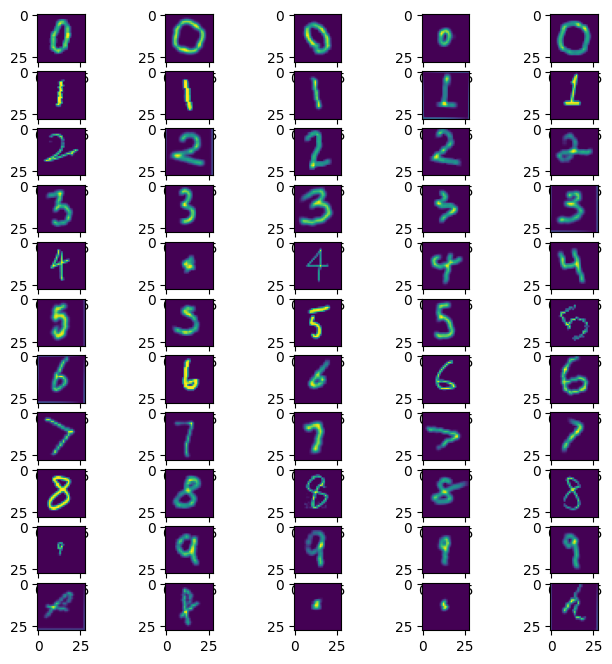

In [37]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 5, 11



img_num = 0 
num = 0 
count =0 
for i in range(len(combined_train)):
  x,y = combined_train[i]
  if y == num: 
    
    figure.add_subplot(rows, cols, img_num+1)
    plt.imshow(x.reshape((28,28)))
    img_num +=1
    count+=1
    if count ==5: 
      num+=1
      count = 0
  if num >10:
    break

plt.show()

## data augmentation 

**Implement** the following cell to use your previously trained CNN as a feature extractor. This is an example of [transfer learning](https://en.wikipedia.org/wiki/Transfer_learning). 

You will need to:
- Freeze the layers of convolutional model you trained
- Change the final linear layer have an additional output for the additional class.  

Here's an example of taking the previously defined LeNet and updating the final layer to have 11 classes instead of 10. This also freezes the other weights in the LeNet. 

```python
# model_conv is a trained LeNet example from above

# Freeze the weights of the model
# The gradients will not be calculated and the optimizer will not
# update the weights
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc3.in_features
model_conv.fc3 = nn.Linear(num_ftrs, 11)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Only parameters of final layer are being optimized not the other weights
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001)
```


In [38]:
print(theoNet5)

NameError: ignored

In [39]:
## split into val and train
#mnist_train, mnist_val = torch.utils.data.random_split(training_mnist, lengths =[int(len(training_mnist)*.80),int(len(training_mnist)*.2)])
class_train, class_val = torch.utils.data.random_split(combined_train, 
                                                       lengths =[int(len(combined_train)*.80),
                                                                 len(combined_train)-int(len(combined_train)*.80)
                                                                 ]
                                                       )

## transfer training loop: 

In [40]:

def class_train_loop(model,criterion, optimizer,BATCH_SIZE, 
               display = True,  EPOCHS = 10, ):
  '''
  the model input needs to have fc3 as the final layer and needs to have already been trained.
  '''
  #BATCH_SIZE = 16
  train_loader = DataLoader(dataset = class_train, batch_size = BATCH_SIZE)
  val_loader = DataLoader(dataset = class_val, batch_size = BATCH_SIZE)

  for epoch in tqdm(range(1,EPOCHS+1), disable = not(display)):
    train_epoch_loss = 0 
    train_epoch_acc = 0
    model.train()## this tells the model that we are training not testing.

    for X_train_batch, y_train_batch in train_loader: 
      #print('kel;;o')
      #print('shape',X_train_batch.shape)

      X_train_batch = X_train_batch.reshape(len(y_train_batch),28*28)#BATCH_SIZE
      ##print()
      #print('shape1',X_train_batch.shape)

      X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
      optimizer.zero_grad()### rests the gradient to 0? 
      #print('X_train_batch.shape',X_train_batch.shape)


      #y_train_pred = model(X_train_batch.float())## forward pass 
      y_train_pred = model(X_train_batch.float(), len(y_train_batch))
      
      #print('predicted')
      #m = nn.Softmax(dim =1)
      #y_train_pred = m(y_train_pred)
      #print('y_train_pred',y_train_pred.shape)

      train_loss = criterion(y_train_pred, y_train_batch.long())#loss(y_train_pred, y_train_batch)
      train_acc = multi_acc(y_train_pred, y_train_batch)
      ## so we need this criterion! instead of loss.

      train_loss.backward()
      optimizer.step()

      train_epoch_loss += train_loss.item()
      train_epoch_acc += train_acc.item()

    with torch.no_grad(): 
      val_epoch_loss = 0 
      val_epoch_acc = 0 
      model.eval()
      for X_val_batch,y_val_batch in val_loader: 
        X_val_batch,y_val_batch = X_val_batch.to(device),y_val_batch.to(device)

        X_val_batch = X_val_batch.reshape(len(y_val_batch),28*28)#BATCH_SIZE

        y_val_pred = model(X_val_batch.float(),len(y_val_batch))

        val_loss = criterion(y_val_pred, y_val_batch.long())
        val_acc = multi_acc(y_val_pred,y_val_batch) 

        val_epoch_loss += val_loss.item()
        val_epoch_acc += val_acc.item()
    loss_stats['train'].append(train_epoch_loss/len(train_loader))
    loss_stats['val'].append(val_epoch_loss/len(val_loader))
    accuracy_stats['train'].append(train_epoch_acc/len(train_loader))
    accuracy_stats['val'].append(val_epoch_acc/len(val_loader))

#train_loop(model,train_loader, val_loader, criterion, optimizer,EPOCHS = 10)




In [ ]:


accuracy_stats = {
    'train': [],
    "val": []
}
loss_stats = {
    'train': [],
    "val": []
}

#theoNet5
#model = theoNet5


theoNet5 = trained_theoNet5
for param in theoNet5.parameters(): 
  param.requires_grad = False ##ignore these parameters. 



num_ftrs = theoNet5.fc3.in_features
theoNet5.fc3 = nn.Linear(num_ftrs, 11)
print(theoNet5.fc3.weight.requires_grad)
theoNet5.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(theoNet5.parameters(), lr = .001)##torch.nn.CrossEntropyLoss()
BATCH_SIZE = 16

class_train_loop(theoNet5,criterion, optimizer,BATCH_SIZE = BATCH_SIZE,EPOCHS = 10, )

plot_scores(accuracy_stats,loss_stats)
print(max(accuracy_stats['val']))

## the accuracy doesn't get better than 12% this probably means that the NN isn't learning anything 
## it might be stuck at bad performance bc the parameters cannot change. 
## maybe the og model isn't performing well? 

## The og model won't train well gets to 8% performance but it isn't the og training loop bc LeNet works fine




**Implement** the following cell to train the final layer of the convolution. Also calculate the test set performance on this fine-tuned model. 

In [51]:
accuracy_stats = {
    'test': [],
}
loss_stats = {
    'test': [],
}

model = theoNet5

class_test = combined_test
#transfer_train_loop(model,criterion, optimizer,BATCH_SIZE, 

def test_loop (model,criterion, optimizer):
  model.to(device)
  test_loader = DataLoader(dataset = class_test, batch_size = BATCH_SIZE)## no epochs or display
  with torch.no_grad(): 
    test_epoch_loss = 0 
    test_epoch_acc = 0 
    model.eval()
    for X_test_batch,y_test_batch in test_loader: 
      #print(X_test_batch)
      #print('1')
      X_test_batch,y_test_batch = X_test_batch.to(device),y_test_batch.to(device)
      #print('2')
      X_test_batch = X_test_batch.reshape(len(y_test_batch),28*28)#BATCH_SIZE

      y_test_pred = model(X_test_batch.float(),len(y_test_batch))

      test_loss = criterion(y_test_pred, y_test_batch.long())
      test_acc = multi_acc(y_test_pred,y_test_batch) 

      test_epoch_loss += test_loss.item()
      test_epoch_acc += test_acc.item()

  loss_stats['test'].append(test_epoch_loss/len(test_loader))
  accuracy_stats['test'].append(test_epoch_acc/len(test_loader))

test_loop(theoNet5,criterion,optimizer)
print('test accuracy:',accuracy_stats['test'][0])

NameError: ignored

***Implement*** the following cell to retrain the linear classifiers (LinearSVM and Softmax). Note that you have an extra class as your model should also detect "not a digit". 

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]C:\Users\theot\Anaconda3\envs\deep_learning\lib\site-packages\torch\autograd\__init__.py:197: UserWarning: An output with one or more elements was resized since it had shape [], which does not match the required output shape [16, 11]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\Resize.cpp:24.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
C:\Users\theot\Anaconda3\envs\deep_learning\lib\site-packages\torch\autograd\__init__.py:197: UserWarning: An output with one or more elements was resized since it had shape [], which does not match the required output shape [3, 11

85.03703703703704


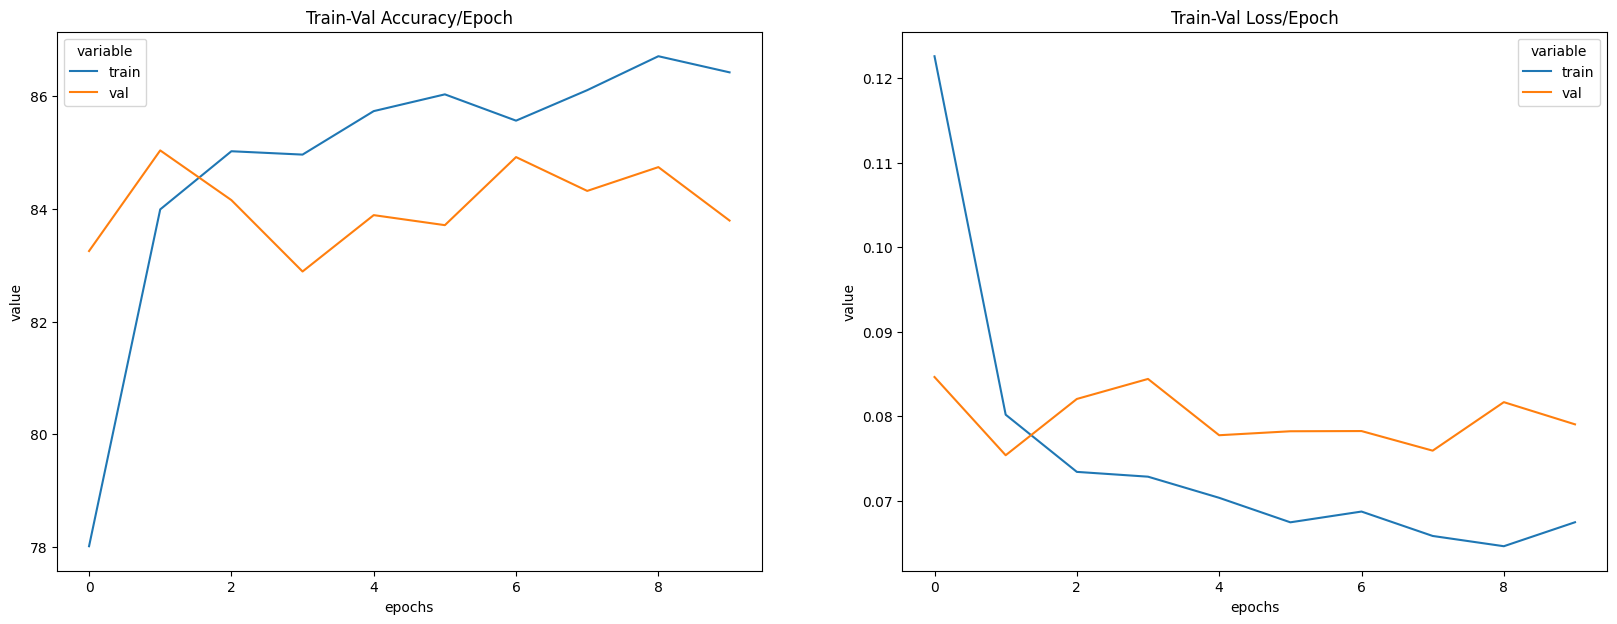

In [43]:
accuracy_stats = {
    'train': [],
    "val": []
}
loss_stats = {
    'train': [],
    "val": []
}

trained_linearSVM = LinearSVM(11)## we are just working with MNIST data for now 
trained_linearSVM.to(device)

criterion = nn.MultiMarginLoss()## svm loss
optimizer = torch.optim.Adam(trained_linearSVM.parameters(), lr = .001)##torch.nn.CrossEntropyLoss()


class_train_loop(trained_linearSVM, criterion, optimizer,EPOCHS = 10,BATCH_SIZE = 16)

plot_scores(accuracy_stats,loss_stats)
print(max(accuracy_stats['val']))

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:17<00:00,  7.72s/it]


88.42222222222222


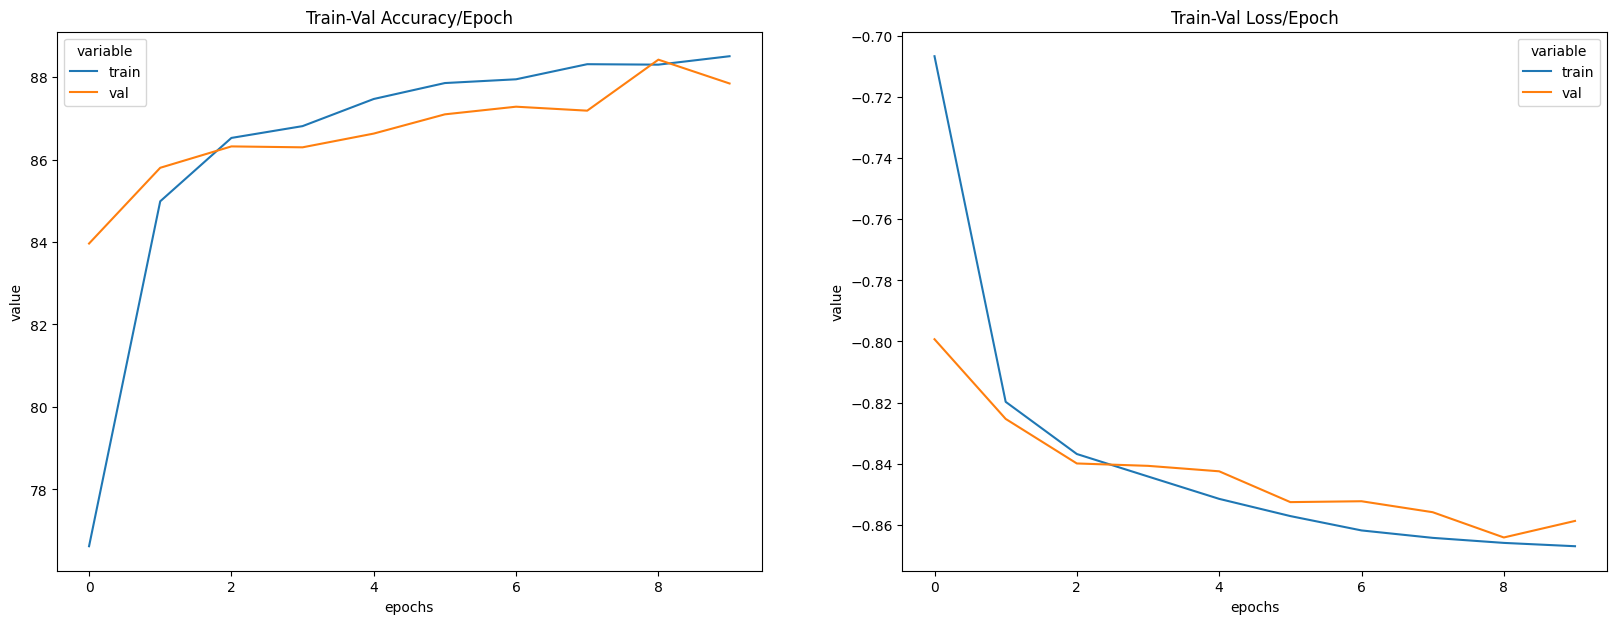

In [44]:
accuracy_stats = {
    'train': [],
    "val": []
}
loss_stats = {
    'train': [],
    "val": []
}
trained_linearSoftmax = LinearSoftmax(11)
#model = LinearSVM(10)## we are just working with MNIST data for now 
trained_linearSoftmax.to(device)

#criterion = nn.CrossEntropyLoss()
criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(trained_linearSoftmax.parameters(), lr = .001)##torch.nn.CrossEntropyLoss()

class_train_loop(trained_linearSoftmax, criterion, optimizer,EPOCHS = 10,BATCH_SIZE = 16)

plot_scores(accuracy_stats,loss_stats)
print(max(accuracy_stats['val']))

***Implement*** the following cell to retrain your previously defined CNN model. 

In [45]:
accuracy_stats = {
    'train': [],
    "val": []
}
loss_stats = {
    'train': [],
    "val": []
}

trained_theoNet5 = TheoNet5(11)## we are just working with MNIST data for now 
trained_theoNet5.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(trained_theoNet5.parameters(), lr = .001)##torch.nn.CrossEntropyLoss()
BATCH_SIZE = 16

class_train_loop(trained_theoNet5,criterion, optimizer,BATCH_SIZE = BATCH_SIZE,EPOCHS = 20, )

plot_scores(accuracy_stats,loss_stats)
print(max(accuracy_stats['val']))

NameError: ignored

**Implement** a visualization of the [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix) on the **new** combined test set with the predictions from your LinearSVM, Softmax, and CNN. You should use a single `Matplotlib` figure with multiple subplots on a single row. 

[See here for examples on using plt.subplots.](https://matplotlib.org/stable/gallery/subplots_axes_and_figures/subplots_demo.html)

In [46]:
from sklearn.metrics import ConfusionMatrixDisplay

In [52]:
class_test = combined_test

def confusion_matrix_loop (model,criterion, optimizer):
  model.to(device)
  test_loader = DataLoader(dataset = class_test, batch_size = len(class_test))## no epochs or display
  with torch.no_grad(): 
    model.eval()
    for X_test_batch,y_test_batch in test_loader: 
      print('1')

      X_test_batch,y_test_batch = X_test_batch.to(device),y_test_batch.to(device)

      X_test_batch = X_test_batch.reshape(len(y_test_batch),28*28)#BATCH_SIZE

      y_test_pred = model(X_test_batch.float(),len(y_test_batch))

  y_pred_softmax = torch.log_softmax(y_test_pred, dim = 1)
  _, y_pred_tags = torch.max(y_pred_softmax, dim = 1) 
  y_test_pred = y_pred_tags


  y_test_batch= y_test_batch.int().cpu()
  y_test_pred = y_test_pred.int().cpu()

  true_values = y_test_batch.numpy().flatten()
  pred_values = y_test_pred.numpy().flatten()
  print(pred_values.shape,true_values.shape)

  ConfusionMatrixDisplay.from_predictions(true_values,pred_values)
  plt.show()

  

  





In [ ]:
confusion_matrix_loop(trained_theoNet5,criterion,optimizer)

1
(10341,) (10341,)


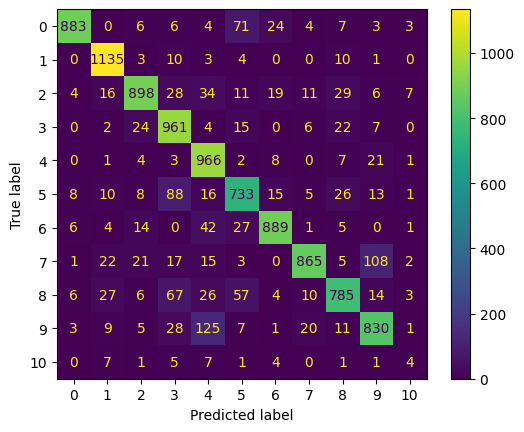

In [53]:
confusion_matrix_loop(trained_linearSVM,criterion,optimizer)

1
(10341,) (10341,)


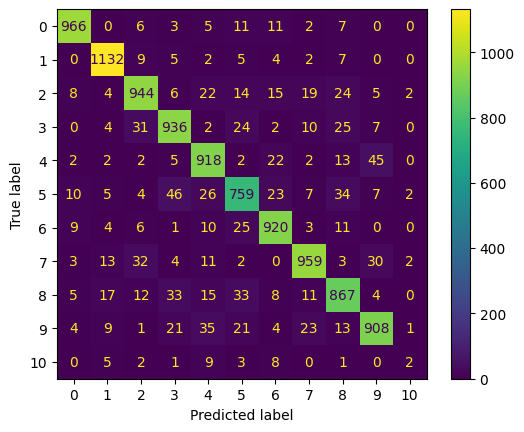

In [54]:
confusion_matrix_loop(trained_linearSoftmax,criterion,optimizer)

In the following cells, write a short report about the performance of your models. You should include the effects of new data, data augmentation, and different architectures. You should also include visualizations as you did before. 

It was super interesting to see how using convolutional layers could dramatically increase the performance of models. Additionally, the pooling layers and overall architecture of CNNs can lead to models that differ widely in thier compute requirements and accuracies. My theoNet5's performance had a test accuracy in the high 90%s whereas the linear models had test accuracies that did not even break 90%

Including the new data and having significant ammounts of augmentation really hurt the performance of our linear models while our CNN was robust enough to adapt to our "messier" data. 

The graphs above show that the way our models learned was largely the same as with our MNIST data, and of course slower with larger ammounts of data. 